# Exercise 8.1A: DNS Traffic Pattern Analysis

**Course**: SS*/AIML* ZG567 - AI and ML Techniques in Cyber Security  
**Module**: 08 - Domain Name Detection  
**Type**: Analytical Exercise  
**Duration**: 2-3 hours  
**Difficulty**: Beginner-Intermediate

---

## 🎯 Scenario

You are a junior SOC analyst at a mid-sized enterprise. Your SIEM has captured 24 hours of DNS queries from the corporate network. Your task is to **establish baseline patterns** for legitimate DNS traffic to prepare for anomaly detection.

## 📋 Learning Objectives

- Understand DNS query structure and components
- Identify characteristics of legitimate domain traffic
- Establish baselines for anomaly detection
- Recognize temporal patterns in network behavior

---

## Setup: Import Required Libraries

In [28]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Task 1: Load and Explore DNS Query Logs

### 1.1 Generate Sample DNS Logs

For this exercise, we'll generate synthetic DNS logs that simulate 24 hours of corporate network traffic.

In [29]:
# Generate sample DNS logs (simulated corporate traffic)
np.random.seed(42)

# Common legitimate domains
legitimate_domains = [
    'google.com', 'microsoft.com', 'amazon.com', 'facebook.com',
    'twitter.com', 'linkedin.com', 'github.com', 'stackoverflow.com',
    'office365.com', 'salesforce.com', 'zoom.us', 'slack.com',
    'dropbox.com', 'atlassian.com', 'adobe.com', 'apple.com'
]

# Generate 10,000 DNS queries over 24 hours
n_queries = 10000
start_time = datetime(2026, 1, 30, 0, 0, 0)

dns_logs = []
for i in range(n_queries):
    # Timestamp: More queries during business hours (8am-6pm)
    hour_offset = np.random.choice(
        range(24),
        p=[0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.03, 0.04,  # 0-7am (sum: 0.15)
           0.08, 0.10, 0.09, 0.09, 0.10, 0.09, 0.08, 0.07,  # 8am-3pm (sum: 0.70)
           0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01]  # 4pm-11pm (sum: 0.15)
    )
    minute_offset = np.random.randint(0, 60)
    second_offset = np.random.randint(0, 60)
    timestamp = start_time + timedelta(hours=int(hour_offset), minutes=int(minute_offset), seconds=int(second_offset))
    
    # Source IP: Simulate corporate network (10.0.0.0/8)
    source_ip = f"10.{np.random.randint(1, 255)}.{np.random.randint(1, 255)}.{np.random.randint(1, 255)}"
    
    # Domain: Mostly legitimate with some random patterns
    if np.random.random() < 0.95:  # 95% legitimate
        domain = np.random.choice(legitimate_domains)
    else:  # 5% suspicious patterns (for later analysis)
        random_string = ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz0123456789'), 
                                                  size=np.random.randint(8, 15)))
        domain = f"{random_string}.com"
    
    # Query type: Mostly A records
    query_type = np.random.choice(['A', 'AAAA', 'CNAME', 'MX'], p=[0.70, 0.15, 0.10, 0.05])
    
    dns_logs.append({
        'timestamp': timestamp,
        'source_ip': source_ip,
        'domain': domain,
        'query_type': query_type
    })

# Create DataFrame
df = pd.DataFrame(dns_logs)
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"✅ Generated {len(df):,} DNS queries")
print(f"📅 Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")

✅ Generated 10,000 DNS queries
📅 Time range: 2026-01-30 00:00:06 to 2026-01-30 23:59:02


### 1.2 Initial Data Exploration

Explore the dataset structure and calculate basic statistics.

In [30]:
# Display first 10 rows
print("=" * 80)
print("SAMPLE DNS LOGS")
print("=" * 80)
display(df.head(10))

# Dataset info
print("\n" + "=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
df.info()

# Calculate summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Unique counts
print(f"\n🔢 Unique Values:")
print(f"   Unique Domains: {df['domain'].nunique():,}")
print(f"   Unique Source IPs: {df['source_ip'].nunique():,}")
print(f"   Unique Query Types: {df['query_type'].nunique()}")

# Top domains
print(f"\n🏆 Top 10 Queried Domains:")
for idx, (domain, count) in enumerate(df['domain'].value_counts().head(10).items(), 1):
    print(f"   {idx:2d}. {domain:30s}: {count:,} queries")

# Most active source IPs
print(f"\n💻 Top 5 Active Source IPs:")
for idx, (ip, count) in enumerate(df['source_ip'].value_counts().head(5).items(), 1):
    print(f"   {idx}. {ip:15s}: {count:,} queries")

# Query type distribution
print(f"\n📊 Query Type Distribution:")
for qtype, count in df['query_type'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"   {qtype:10s}: {count:,} ({percentage:.1f}%)")

SAMPLE DNS LOGS


,timestamp,source_ip,domain,query_type
0,2026-01-30 00:00:06,10.24.140.63,linkedin.com,A
1,2026-01-30 00:00:14,10.32.252.9,stackoverflow.com,A
2,2026-01-30 00:00:23,10.160.55.33,slack.com,A
3,2026-01-30 00:00:27,10.100.148.176,salesforce.com,MX
4,2026-01-30 00:00:41,10.254.171.188,github.com,A
5,2026-01-30 00:01:24,10.254.190.64,salesforce.com,A
6,2026-01-30 00:01:26,10.238.235.211,office365.com,AAAA
7,2026-01-30 00:01:35,10.146.5.19,atlassian.com,A
8,2026-01-30 00:01:36,10.134.108.18,linkedin.com,A
9,2026-01-30 00:01:45,10.211.211.60,twitter.com,A



DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   10000 non-null  datetime64[ns]
 1   source_ip   10000 non-null  object        
 2   domain      10000 non-null  object        
 3   query_type  10000 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 312.6+ KB

SUMMARY STATISTICS

🔢 Unique Values:
   Unique Domains: 504
   Unique Source IPs: 9,997
   Unique Query Types: 4

🏆 Top 10 Queried Domains:
    1. linkedin.com                  : 642 queries
    2. twitter.com                   : 623 queries
    3. zoom.us                       : 617 queries
    4. amazon.com                    : 617 queries
    5. office365.com                 : 601 queries
    6. dropbox.com                   : 596 queries
    7. apple.com                     : 596 queries
    8. atlassian.com     

## Task 2: Domain Characteristic Analysis

### 2.1 Extract Domain Components

Parse domains to extract TLD, SLD, and other components.

In [31]:
def parse_domain(domain):
    """
    Extract components from domain name.
    
    Args:
        domain (str): Domain name (e.g., 'www.example.com')
        
    Returns:
        dict: Domain components
    """
    try:
        parts = domain.split('.')
        if len(parts) < 2:
            return {'sld': domain, 'tld': None, 'subdomain_count': 0, 'length': len(domain)}
        
        tld = parts[-1]
        sld = parts[-2] if len(parts) >= 2 else None
        subdomain_count = len(parts) - 2 if len(parts) > 2 else 0
        
        return {
            'sld': sld,
            'tld': tld,
            'subdomain_count': subdomain_count,
            'length': len(sld) if sld else 0
        }
    except:
        return {'sld': None, 'tld': None, 'subdomain_count': 0, 'length': 0}

# Apply domain parsing
domain_components = df['domain'].apply(parse_domain).apply(pd.Series)
df = pd.concat([df, domain_components], axis=1)

print("✅ Domain components extracted")
display(df[['domain', 'sld', 'tld', 'subdomain_count', 'length']].head(10))

✅ Domain components extracted


,domain,sld,tld,subdomain_count,length
0,linkedin.com,linkedin,com,0,8
1,stackoverflow.com,stackoverflow,com,0,13
2,slack.com,slack,com,0,5
3,salesforce.com,salesforce,com,0,10
4,github.com,github,com,0,6
5,salesforce.com,salesforce,com,0,10
6,office365.com,office365,com,0,9
7,atlassian.com,atlassian,com,0,9
8,linkedin.com,linkedin,com,0,8
9,twitter.com,twitter,com,0,7


### 2.2 Analyze TLD Distribution

Analyze the distribution of Top-Level Domains (TLDs) in the traffic.

TLD Distribution Analysis:
com       :  9,383 queries (93.83%)
us        :    617 queries ( 6.17%)


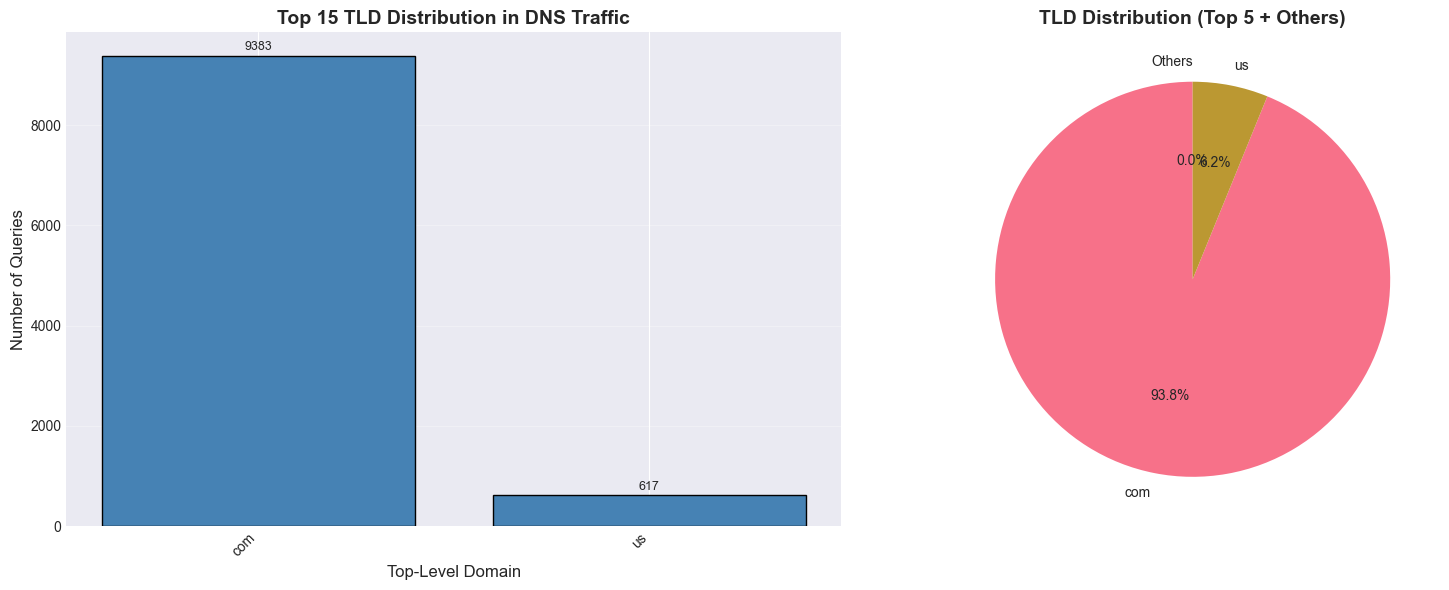


✅ Most common TLD: .com (9,383 queries)


In [32]:
# Count TLD occurrences
tld_counts = df['tld'].value_counts().head(15)

print("TLD Distribution Analysis:")
print("=" * 60)
for tld, count in tld_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{tld:10s}: {count:6,} queries ({percentage:5.2f}%)")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1.bar(range(len(tld_counts)), tld_counts.values, color='steelblue', edgecolor='black')
ax1.set_xticks(range(len(tld_counts)))
ax1.set_xticklabels(tld_counts.index, rotation=45, ha='right')
ax1.set_title('Top 15 TLD Distribution in DNS Traffic', fontsize=14, fontweight='bold')
ax1.set_xlabel('Top-Level Domain', fontsize=12)
ax1.set_ylabel('Number of Queries', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(tld_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=9)

# Pie chart for top 5
top_5_tlds = tld_counts.head(5)
others = tld_counts[5:].sum()
tld_pie_data = list(top_5_tlds.values) + [others]
tld_pie_labels = list(top_5_tlds.index) + ['Others']
ax2.pie(tld_pie_data, labels=tld_pie_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('TLD Distribution (Top 5 + Others)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Most common TLD: .{tld_counts.index[0]} ({tld_counts.values[0]:,} queries)")

### 2.3 Domain Length Analysis

Analyze the distribution of domain lengths (SLD length).

Domain Length Statistics:
Mean:       7.48 characters
Median:     7 characters
Std Dev:    2.37
Min:        4 characters
Max:        14 characters
25th %ile:  6 characters
75th %ile:  9 characters

✅ Analysis: Most domains have length between 6 and 9 characters


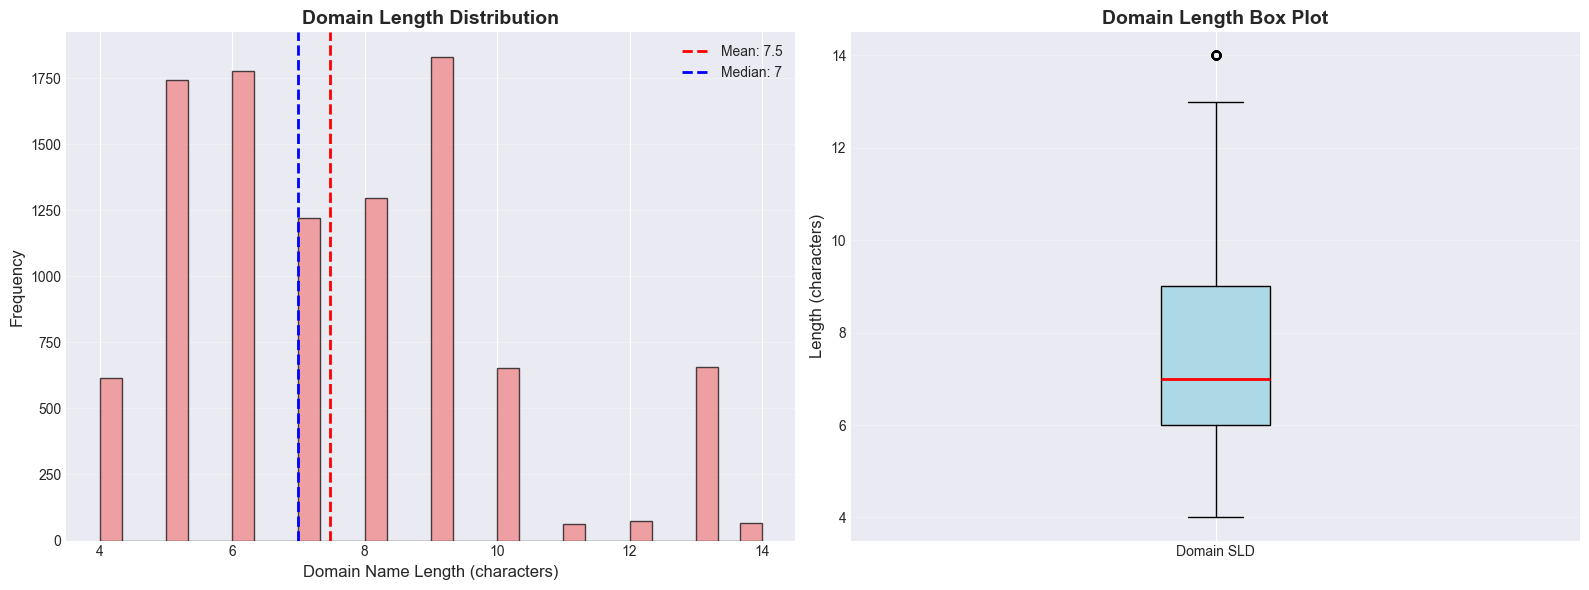

In [33]:
# Calculate length statistics
print("Domain Length Statistics:")
print("=" * 60)
print(f"Mean:       {df['length'].mean():.2f} characters")
print(f"Median:     {df['length'].median():.0f} characters")
print(f"Std Dev:    {df['length'].std():.2f}")
print(f"Min:        {df['length'].min():.0f} characters")
print(f"Max:        {df['length'].max():.0f} characters")
print(f"25th %ile:  {df['length'].quantile(0.25):.0f} characters")
print(f"75th %ile:  {df['length'].quantile(0.75):.0f} characters")

print(f"\n✅ Analysis: Most domains have length between {df['length'].quantile(0.25):.0f} and {df['length'].quantile(0.75):.0f} characters")

# Create comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(df['length'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0].axvline(df['length'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['length'].mean():.1f}")
axes[0].axvline(df['length'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: {df['length'].median():.0f}")
axes[0].set_title('Domain Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Domain Name Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df['length'], vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', edgecolor='black'),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='black'),
               capprops=dict(color='black'))
axes[1].set_title('Domain Length Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Length (characters)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(['Domain SLD'])

plt.tight_layout()
plt.show()

### 2.4 Character Composition Analysis

Analyze the ratio of digits vs. alphabetic characters in domain names.

Character Composition Analysis:
Domains with digits:    1,077 (10.8%)
Domains all alphabetic: 8,923 (89.2%)
Average digit ratio:    0.0335
Average alpha ratio:    0.9665

✅ Insight: 89.2% of domains are purely alphabetic (no digits)


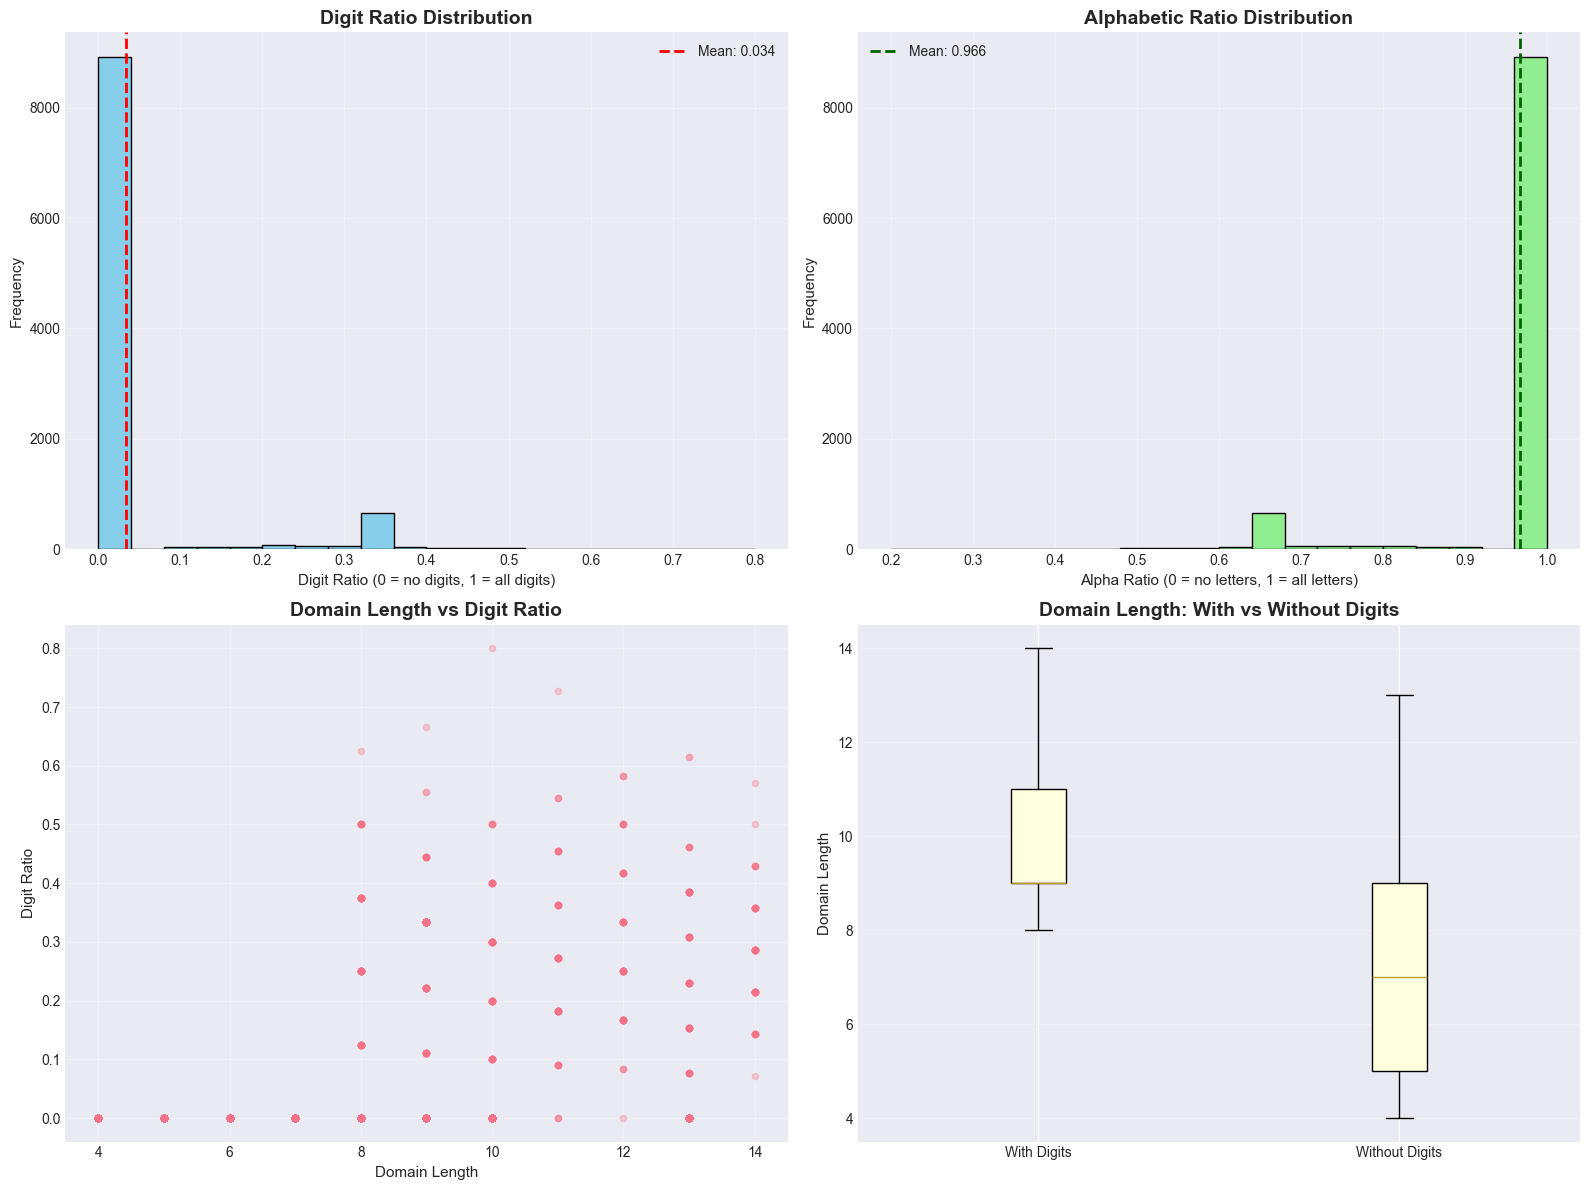

In [34]:
def analyze_character_composition(domain):
    """
    Analyze character composition of domain SLD.
    
    Returns:
        dict: Character composition metrics
    """
    sld = domain.split('.')[0] if '.' in domain else domain
    
    digit_count = sum(c.isdigit() for c in sld)
    alpha_count = sum(c.isalpha() for c in sld)
    total = len(sld)
    
    return {
        'digit_ratio': digit_count / total if total > 0 else 0,
        'alpha_ratio': alpha_count / total if total > 0 else 0,
        'has_digits': digit_count > 0
    }

# Apply composition analysis
char_comp = df['domain'].apply(analyze_character_composition).apply(pd.Series)
df = pd.concat([df, char_comp], axis=1)

# Analyze character composition patterns
print("Character Composition Analysis:")
print("=" * 60)
print(f"Domains with digits:    {df['has_digits'].sum():,} ({df['has_digits'].sum()/len(df)*100:.1f}%)")
print(f"Domains all alphabetic: {(df['digit_ratio'] == 0).sum():,} ({(df['digit_ratio'] == 0).sum()/len(df)*100:.1f}%)")
print(f"Average digit ratio:    {df['digit_ratio'].mean():.4f}")
print(f"Average alpha ratio:    {df['alpha_ratio'].mean():.4f}")

print(f"\n✅ Insight: {(df['digit_ratio'] == 0).sum()/len(df)*100:.1f}% of domains are purely alphabetic (no digits)")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Digit ratio distribution
axes[0, 0].hist(df['digit_ratio'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].axvline(df['digit_ratio'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {df['digit_ratio'].mean():.3f}")
axes[0, 0].set_title('Digit Ratio Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Digit Ratio (0 = no digits, 1 = all digits)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Alpha ratio distribution
axes[0, 1].hist(df['alpha_ratio'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(df['alpha_ratio'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                   label=f"Mean: {df['alpha_ratio'].mean():.3f}")
axes[0, 1].set_title('Alphabetic Ratio Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Alpha Ratio (0 = no letters, 1 = all letters)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Scatter plot: digit ratio vs domain length
axes[1, 0].scatter(df['length'], df['digit_ratio'], alpha=0.3, s=20)
axes[1, 0].set_title('Domain Length vs Digit Ratio', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Domain Length', fontsize=11)
axes[1, 0].set_ylabel('Digit Ratio', fontsize=11)
axes[1, 0].grid(alpha=0.3)

# 4. Box plot comparison
has_digits_data = [df[df['has_digits']]['length'], df[~df['has_digits']]['length']]
axes[1, 1].boxplot(has_digits_data, labels=['With Digits', 'Without Digits'],
                    patch_artist=True,
                   boxprops=dict(facecolor='lightyellow', edgecolor='black'))
axes[1, 1].set_title('Domain Length: With vs Without Digits', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Domain Length', fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Task 3: Temporal Pattern Analysis

### 3.1 Queries by Hour of Day

Analyze when DNS queries occur throughout the day.

Temporal Pattern Analysis:

Queries by Hour:
   0:00 -  189 queries █
   1:00 -   93 queries 
   2:00 -   98 queries 
   3:00 -  103 queries █
   4:00 -  119 queries █
   5:00 -  210 queries ██
   6:00 -  317 queries ███
   7:00 -  390 queries ███
   8:00 -  807 queries ████████
   9:00 - 1,031 queries ██████████
  10:00 -  918 queries █████████
  11:00 -  892 queries ████████
  12:00 -  942 queries █████████
  13:00 -  941 queries █████████
  14:00 -  778 queries ███████
  15:00 -  668 queries ██████
  16:00 -  499 queries ████
  17:00 -  318 queries ███
  18:00 -  195 queries █
  19:00 -  107 queries █
  20:00 -  113 queries █
  21:00 -   76 queries 
  22:00 -  104 queries █
  23:00 -   92 queries 

Peak hour: 9:00 with 1,031 queries
Lowest hour: 21:00 with 76 queries

✅ Business hours account for 77.9% of all queries


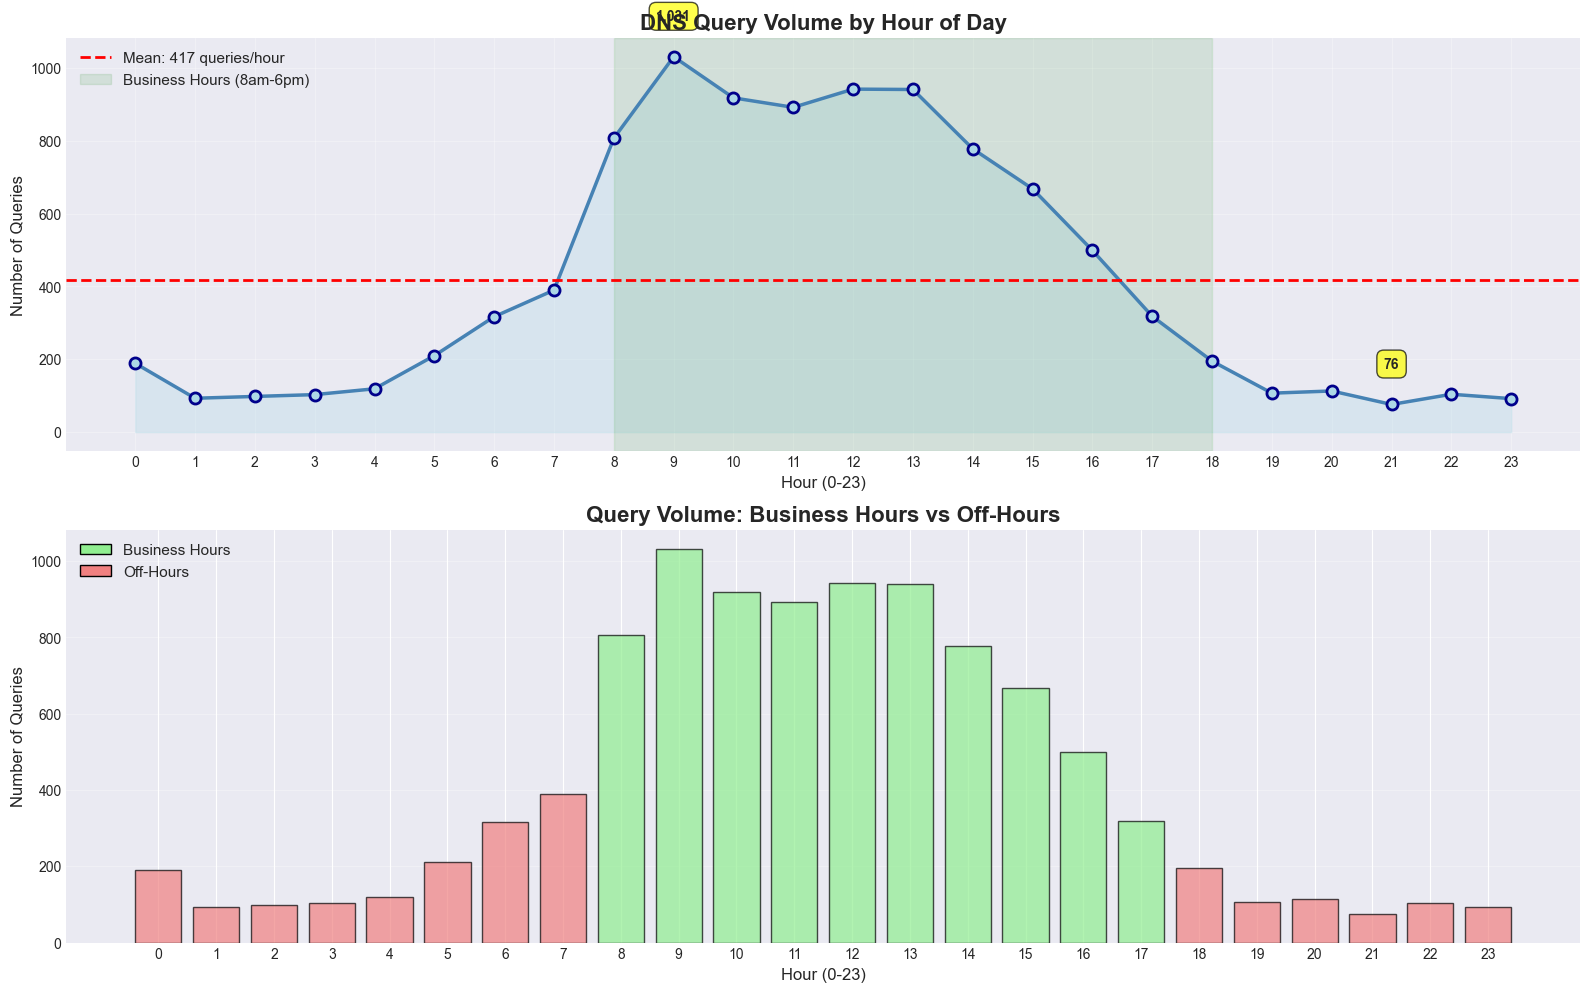

In [35]:
# Extract hour from timestamp
df['hour'] = df['timestamp'].dt.hour

# Count queries per hour
hourly_counts = df.groupby('hour').size()

print("Temporal Pattern Analysis:")
print("=" * 60)
print("\nQueries by Hour:")
for hour, count in hourly_counts.items():
    bar = '█' * int(count / 100)
    print(f"  {hour:2d}:00 - {count:4,} queries {bar}")

print(f"\nPeak hour: {hourly_counts.idxmax()}:00 with {hourly_counts.max():,} queries")
print(f"Lowest hour: {hourly_counts.idxmin()}:00 with {hourly_counts.min():,} queries")

# Create comprehensive temporal visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

print(f"\n✅ Business hours account for {hourly_counts[8:18].sum()/len(df)*100:.1f}% of all queries")

# Line plot with markers

# Line plot with markers
axes[0].plot(hourly_counts.index, hourly_counts.values, marker='o', linewidth=2.5, 
             markersize=8, color='steelblue', markerfacecolor='lightblue', 
             markeredgecolor='darkblue', markeredgewidth=2)
axes[0].fill_between(hourly_counts.index, hourly_counts.values, alpha=0.3, color='lightblue')
axes[0].axhline(hourly_counts.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {hourly_counts.mean():.0f} queries/hour')
axes[0].axvspan(8, 18, alpha=0.1, color='green', label='Business Hours (8am-6pm)')
axes[0].set_title('DNS Query Volume by Hour of Day', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Hour (0-23)', fontsize=12)
axes[0].set_ylabel('Number of Queries', fontsize=12)
axes[0].set_xticks(range(24))
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add value labels on peaks
for hour in [hourly_counts.idxmax(), hourly_counts.idxmin()]:
    axes[0].annotate(f'{hourly_counts[hour]:,}', 
                    xy=(hour, hourly_counts[hour]),
                    xytext=(hour, hourly_counts[hour] + 100),
                    ha='center',
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Bar chart for comparison
colors = ['lightcoral' if (h < 8 or h >= 18) else 'lightgreen' for h in hourly_counts.index]
axes[1].bar(hourly_counts.index, hourly_counts.values, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Query Volume: Business Hours vs Off-Hours', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Hour (0-23)', fontsize=12)
axes[1].set_ylabel('Number of Queries', fontsize=12)
axes[1].set_xticks(range(24))
axes[1].grid(axis='y', alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightgreen', edgecolor='black', label='Business Hours'),
                    Patch(facecolor='lightcoral', edgecolor='black', label='Off-Hours')]
axes[1].legend(handles=legend_elements, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

### 3.2 Business Hours vs. Off-Hours Analysis

Compare DNS patterns during business hours (8am-6pm) vs. off-hours.

Business Hours vs Off-Hours Analysis:

✅ Key Insight: Business hours show 3.5x more activity than off-hours

📊 Query Volume:
   Business Hours: 7,794 queries (77.9%)
   Off-Hours:      2,206 queries (22.1%)

🌐 Unique Domains:
   Business Hours: 382 unique domains
   Off-Hours:      138 unique domains

💻 Unique Source IPs:
   Business Hours: 7,791 unique IPs
   Off-Hours:      2,206 unique IPs

📏 Average Domain Length:
   Business Hours: 7.48 characters
   Off-Hours:      7.50 characters

🔢 Query Types Distribution:

   Business Hours:
      A         : 5,453 ( 70.0%)
      AAAA      : 1,183 ( 15.2%)
      CNAME     :   749 (  9.6%)
      MX        :   409 (  5.2%)

   Off-Hours:
      A         : 1,539 ( 69.8%)
      AAAA      :   355 ( 16.1%)
      CNAME     :   211 (  9.6%)
      MX        :   101 (  4.6%)


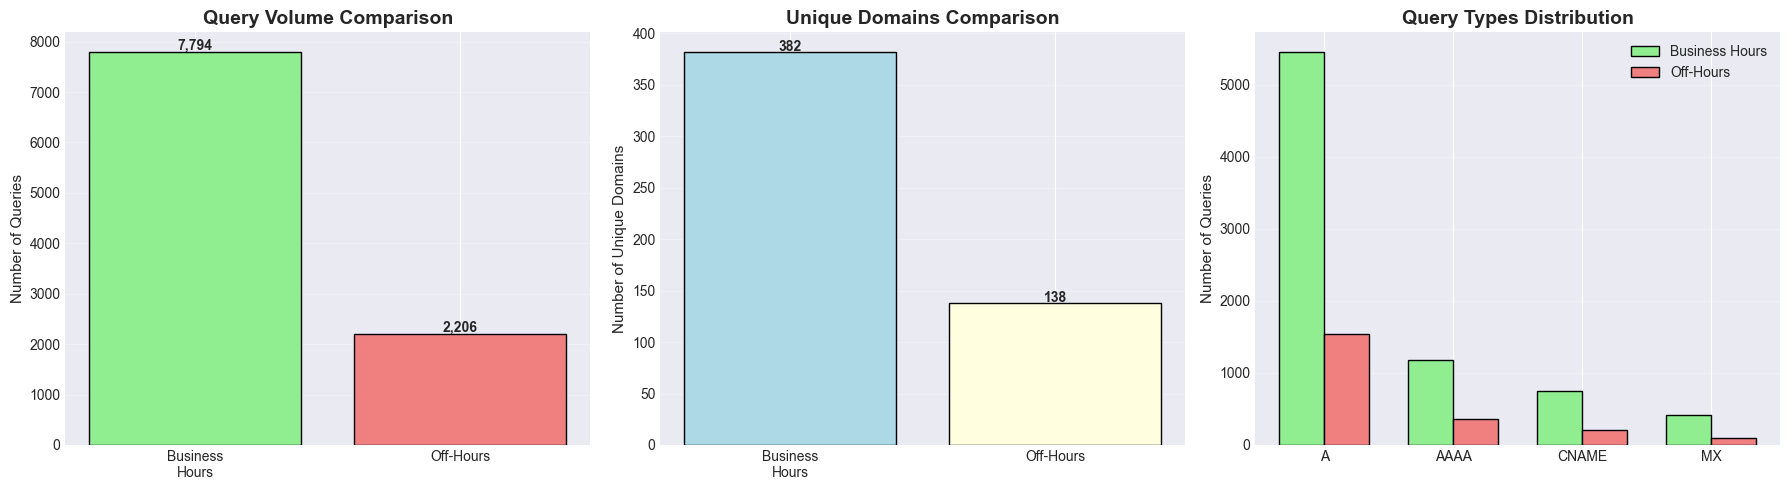

In [38]:
# Define business hours
def categorize_time(hour):
    if 8 <= hour < 18:
        return 'Business Hours'
    else:
        return 'Off-Hours'

df['time_category'] = df['hour'].apply(categorize_time)

# Compare statistics between business hours and off-hours
print("Business Hours vs Off-Hours Analysis:")
print("=" * 70)

business_df = df[df['time_category'] == 'Business Hours']
off_hours_df = df[df['time_category'] == 'Off-Hours']

print(f"\n✅ Key Insight: Business hours show {(len(business_df)/len(off_hours_df)):.1f}x more activity than off-hours")

print(f"\n📊 Query Volume:")
print(f"   Business Hours: {len(business_df):,} queries ({len(business_df)/len(df)*100:.1f}%)")
print(f"   Off-Hours:      {len(off_hours_df):,} queries ({len(off_hours_df)/len(df)*100:.1f}%)")

print(f"\n🌐 Unique Domains:")
print(f"   Business Hours: {business_df['domain'].nunique():,} unique domains")
print(f"   Off-Hours:      {off_hours_df['domain'].nunique():,} unique domains")

print(f"\n💻 Unique Source IPs:")
print(f"   Business Hours: {business_df['source_ip'].nunique():,} unique IPs")
print(f"   Off-Hours:      {off_hours_df['source_ip'].nunique():,} unique IPs")

print(f"\n📏 Average Domain Length:")
print(f"   Business Hours: {business_df['length'].mean():.2f} characters")
print(f"   Off-Hours:      {off_hours_df['length'].mean():.2f} characters")

print(f"\n🔢 Query Types Distribution:")

print("\n   Business Hours:")
for qtype, count in business_df['query_type'].value_counts().items():
    percentage = (count / len(business_df)) * 100
    print(f"      {qtype:10s}: {count:5,} ({percentage:5.1f}%)")

print("\n   Off-Hours:")
for qtype, count in off_hours_df['query_type'].value_counts().items():
    percentage = (count / len(off_hours_df)) * 100
    print(f"      {qtype:10s}: {count:5,} ({percentage:5.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Query volume comparison
categories = ['Business\nHours', 'Off-Hours']
volumes = [len(business_df), len(off_hours_df)]
axes[0].bar(categories, volumes, color=['lightgreen', 'lightcoral'], edgecolor='black')
for i, v in enumerate(volumes):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')
axes[0].set_title('Query Volume Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Queries', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Unique domains comparison
unique_domains = [business_df['domain'].nunique(), off_hours_df['domain'].nunique()]
axes[1].bar(categories, unique_domains, color=['lightblue', 'lightyellow'], edgecolor='black')
axes[1].set_title('Unique Domains Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Unique Domains', fontsize=11)
for i, v in enumerate(unique_domains):
    axes[1].text(i, v + 0.5, f'{v:,}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Query types comparison
qtypes = ['A', 'AAAA', 'CNAME', 'MX']
business_qtype_counts = [business_df[business_df['query_type'] == qt].shape[0] for qt in qtypes]
off_hours_qtype_counts = [off_hours_df[off_hours_df['query_type'] == qt].shape[0] for qt in qtypes]

x = np.arange(len(qtypes))
width = 0.35
axes[2].bar(x - width/2, business_qtype_counts, width, label='Business Hours', 
            color='lightgreen', edgecolor='black')
axes[2].bar(x + width/2, off_hours_qtype_counts, width, label='Off-Hours', 
            color='lightcoral', edgecolor='black')
axes[2].set_title('Query Types Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Number of Queries', fontsize=11)
axes[2].set_xticks(x)
axes[2].set_xticklabels(qtypes)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Task 4: Create Baseline Profile

### 4.1 Calculate Baseline Statistics

Document normal characteristics of legitimate DNS traffic.

In [40]:
# Calculate comprehensive baseline statistics

baseline_profile = {
    'total_queries': len(df),
    'unique_domains': df['domain'].nunique(),
    'unique_source_ips': df['source_ip'].nunique(),
    
    # Domain length statistics
    'avg_domain_length': df['length'].mean(),
    'median_domain_length': df['length'].median(),
    'std_domain_length': df['length'].std(),
    'min_domain_length': df['length'].min(),
    'max_domain_length': df['length'].max(),
    
    # TLD statistics
    'most_common_tld': df['tld'].value_counts().index[0] if len(df) > 0 else None,
    'top_5_tlds': list(df['tld'].value_counts().head(5).index),
    'unique_tlds': df['tld'].nunique(),
    
    # Character composition
    'avg_digit_ratio': df['digit_ratio'].mean(),
    'avg_alpha_ratio': df['alpha_ratio'].mean(),
    'pct_domains_with_digits': (df['has_digits'].sum() / len(df)) * 100,
    
    # Temporal patterns
    'business_hours_pct': (df[df['time_category'] == 'Business Hours'].shape[0] / len(df)) * 100,
    'peak_hour': df['hour'].value_counts().idxmax(),
    'lowest_hour': df['hour'].value_counts().idxmin(),
    
    # Query type distribution
    'query_type_A_pct': (df[df['query_type'] == 'A'].shape[0] / len(df)) * 100,
    'query_type_AAAA_pct': (df[df['query_type'] == 'AAAA'].shape[0] / len(df)) * 100,
    'query_type_CNAME_pct': (df[df['query_type'] == 'CNAME'].shape[0] / len(df)) * 100,
    'query_type_MX_pct': (df[df['query_type'] == 'MX'].shape[0] / len(df)) * 100,
    
    # Subdomain statistics
    'pct_with_subdomains': (df[df['subdomain_count'] > 0].shape[0] / len(df)) * 100,
    'avg_subdomain_count': df['subdomain_count'].mean(),
}

print("=" * 80)
print("BASELINE PROFILE: LEGITIMATE DNS TRAFFIC")
print("=" * 80)
for key, value in baseline_profile.items():
    print(f"{key:30s}: {value}")

BASELINE PROFILE: LEGITIMATE DNS TRAFFIC
total_queries                 : 10000
unique_domains                : 504
unique_source_ips             : 9997
avg_domain_length             : 7.4835
median_domain_length          : 7.0
std_domain_length             : 2.371305560025089
min_domain_length             : 4
max_domain_length             : 14
most_common_tld               : com
top_5_tlds                    : ['com', 'us']
unique_tlds                   : 2
avg_digit_ratio               : 0.03352359584859585
avg_alpha_ratio               : 0.9664764041514041
pct_domains_with_digits       : 10.77
business_hours_pct            : 77.94
peak_hour                     : 9
lowest_hour                   : 21
query_type_A_pct              : 69.92
query_type_AAAA_pct           : 15.379999999999999
query_type_CNAME_pct          : 9.6
query_type_MX_pct             : 5.1
pct_with_subdomains           : 0.0
avg_subdomain_count           : 0.0


### 4.2 Define Anomaly Detection Thresholds

Based on baseline analysis, define thresholds for flagging suspicious domains.

In [42]:
# Define anomaly detection rules based on baseline analysis

# Calculate dynamic thresholds from baseline
mean_length = df['length'].mean()
std_length = df['length'].std()
mean_digit_ratio = df['digit_ratio'].mean()
std_digit_ratio = df['digit_ratio'].std()

anomaly_thresholds = {
    # Rule 1: Domain length (mean + 2*std for 95% confidence)
    'max_normal_length': mean_length + (2 * std_length),
    'min_normal_length': max(0, mean_length - (2 * std_length)),
    
    # Rule 2: Digit ratio (unusually high digit presence)
    'max_digit_ratio': mean_digit_ratio + (2 * std_digit_ratio),
    
    # Rule 3: Suspicious TLDs (free TLDs often abused in malware campaigns)
    'suspicious_tlds': ['.tk', '.ml', '.ga', '.cf', '.gq', '.pw', '.cc', '.xyz', '.top'],
    
    # Rule 4: Subdomain count (excessive subdomains may indicate tunneling)
    'max_subdomain_count': 3,
    
    # Rule 5: Off-hours activity threshold
    # Flag IPs with more than this many queries during off-hours
    'off_hours_query_threshold': 100,
    
    # Rule 6: Character randomness
    # Domains with very high digit ratios are suspicious
    'high_digit_ratio_threshold': 0.5,
    
    # Rule 7: Uncommon query types
    'normal_query_types': ['A', 'AAAA', 'CNAME', 'MX'],
}

print("=" * 80)
print("ANOMALY DETECTION THRESHOLDS")
print("=" * 80)
for key, value in anomaly_thresholds.items():
    print(f"{key:30s}: {value}")

ANOMALY DETECTION THRESHOLDS
max_normal_length             : 12.226111120050177
min_normal_length             : 2.7408888799498223
max_digit_ratio               : 0.23488152180775845
suspicious_tlds               : ['.tk', '.ml', '.ga', '.cf', '.gq', '.pw', '.cc', '.xyz', '.top']
max_subdomain_count           : 3
off_hours_query_threshold     : 100
high_digit_ratio_threshold    : 0.5
normal_query_types            : ['A', 'AAAA', 'CNAME', 'MX']


### 4.3 Apply Anomaly Detection Rules

Test your thresholds by flagging potentially suspicious domains.

In [44]:
# Implement anomaly detection function

def flag_suspicious_domain(row, thresholds):
    """
    Flag domain as suspicious based on multiple rules.
    
    Returns:
        tuple: (is_suspicious, reasons)
    """
    reasons = []
    
    # Rule 1: Abnormal domain length
    if row['length'] > thresholds['max_normal_length']:
        reasons.append(f"Excessive length ({row['length']:.0f} chars > {thresholds['max_normal_length']:.0f})")
    elif row['length'] < thresholds['min_normal_length']:
        reasons.append(f"Too short ({row['length']:.0f} chars < {thresholds['min_normal_length']:.0f})")
    
    # Rule 2: High digit ratio
    if row['digit_ratio'] > thresholds['high_digit_ratio_threshold']:
        reasons.append(f"High digit ratio ({row['digit_ratio']:.2f})")
    
    # Rule 3: Suspicious TLD
    if f".{row['tld']}" in thresholds['suspicious_tlds']:
        reasons.append(f"Suspicious TLD (.{row['tld']})")
    
    # Rule 4: Excessive subdomains
    if row['subdomain_count'] > thresholds['max_subdomain_count']:
        reasons.append(f"Too many subdomains ({row['subdomain_count']})")
    
    is_suspicious = len(reasons) > 0
    return is_suspicious, reasons

# Apply detection    
print("Applying anomaly detection rules...")
detection_results = df.apply(lambda row: flag_suspicious_domain(row, anomaly_thresholds), axis=1)
df['suspicious'] = detection_results.apply(lambda x: x[0])
df['reasons'] = detection_results.apply(lambda x: '; '.join(x[1]) if x[1] else '')

# Display flagged domains    
suspicious_domains = df[df['suspicious']]

print("=" * 80)
print("ANOMALY DETECTION RESULTS")
print("=" * 80)
print(f"\n🚨 Flagged {len(suspicious_domains):,} suspicious domains ({len(suspicious_domains)/len(df)*100:.2f}%)")
print(f"✅ {len(df) - len(suspicious_domains):,} domains passed all checks ({(len(df) - len(suspicious_domains))/len(df)*100:.2f}%)")

if len(suspicious_domains) > 0:
    print("\n🔍 Top 15 Suspicious Domains:")
    display(suspicious_domains[['domain', 'length', 'digit_ratio', 'tld', 'subdomain_count', 'reasons']].head(15))
    
    # Analyze reasons for flagging
    print("\n📊 Flagging Reasons Distribution:")
    all_reasons = []
    for reasons_str in suspicious_domains['reasons']:
        all_reasons.extend(reasons_str.split('; '))
    reason_counts = Counter(all_reasons)
    for reason, count in reason_counts.most_common():
        print(f"   • {reason}: {count} domains")
else:
    print("\n✅ No suspicious domains detected with current thresholds")


Applying anomaly detection rules...
ANOMALY DETECTION RESULTS

🚨 Flagged 735 suspicious domains (7.35%)
✅ 9,265 domains passed all checks (92.65%)

🔍 Top 15 Suspicious Domains:


,domain,length,digit_ratio,tld,subdomain_count,reasons
1,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
12,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
16,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
26,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
27,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
50,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
55,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
78,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
95,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)
96,stackoverflow.com,13,0.000000,com,0,Excessive length (13 chars > 12)



📊 Flagging Reasons Distribution:
   • Excessive length (13 chars > 12): 657 domains
   • Excessive length (14 chars > 12): 66 domains
   • High digit ratio (0.58): 3 domains
   • High digit ratio (0.62): 3 domains
   • High digit ratio (0.55): 3 domains
   • High digit ratio (0.56): 2 domains
   • High digit ratio (0.80): 1 domains
   • High digit ratio (0.73): 1 domains
   • High digit ratio (0.57): 1 domains
   • High digit ratio (0.67): 1 domains


## Deliverable: Summary Report

### Create a summary of your findings

In [46]:
# Generate comprehensive summary report

print("="*80)
print("DNS TRAFFIC BASELINE ANALYSIS - SUMMARY REPORT")
print("="*80)

print("\n📊 DATASET OVERVIEW")
print("-" * 80)
print(f"Total DNS Queries: {len(df):,}")
print(f"Unique Domains: {df['domain'].nunique():,}")
print(f"Unique Source IPs: {df['source_ip'].nunique():,}")
print(f"Time Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: 24 hours")

print("\n🌐 DOMAIN CHARACTERISTICS")
print("-" * 80)
print(f"Average Domain Length: {baseline_profile['avg_domain_length']:.2f} characters")
print(f"Length Range: {baseline_profile['min_domain_length']:.0f} - {baseline_profile['max_domain_length']:.0f} characters")
print(f"Most Common TLD: .{baseline_profile['most_common_tld']}")
print(f"Top 5 TLDs: {', '.join([f'.{tld}' for tld in baseline_profile['top_5_tlds']])}")
print(f"Unique TLDs: {baseline_profile['unique_tlds']}")
print(f"Domains with Digits: {baseline_profile['pct_domains_with_digits']:.1f}%")
print(f"Average Digit Ratio: {baseline_profile['avg_digit_ratio']:.4f}")
print(f"Domains with Subdomains: {baseline_profile['pct_with_subdomains']:.1f}%")

print("\n⏰ TEMPORAL PATTERNS")
print("-" * 80)
print(f"Business Hours Activity: {baseline_profile['business_hours_pct']:.1f}%")
print(f"Off-Hours Activity: {100 - baseline_profile['business_hours_pct']:.1f}%")
print(f"Peak Activity Hour: {baseline_profile['peak_hour']}:00")
print(f"Lowest Activity Hour: {baseline_profile['lowest_hour']}:00")

print("\n📋 QUERY TYPE DISTRIBUTION")
print("-" * 80)
print(f"A Records:     {baseline_profile['query_type_A_pct']:.1f}%")
print(f"AAAA Records:  {baseline_profile['query_type_AAAA_pct']:.1f}%")
print(f"CNAME Records: {baseline_profile['query_type_CNAME_pct']:.1f}%")
print(f"MX Records:    {baseline_profile['query_type_MX_pct']:.1f}%")

print("\n🚨 ANOMALY DETECTION RESULTS")
print("-" * 80)
if 'suspicious' in df.columns:
    suspicious_count = df['suspicious'].sum()
    print(f"Suspicious Domains Flagged: {suspicious_count:,} ({suspicious_count/len(df)*100:.2f}%)")
    print(f"Clean Domains: {len(df) - suspicious_count:,} ({(len(df) - suspicious_count)/len(df)*100:.2f}%)")
    
    if suspicious_count > 0:
        print(f"\nTop Suspicious Domain: {suspicious_domains.iloc[0]['domain']}")
        print(f"Reason: {suspicious_domains.iloc[0]['reasons']}")
else:
    print("Anomaly detection not yet applied")

print("\n🎯 KEY FINDINGS")
print("-" * 80)
print("1. Legitimate traffic follows predictable patterns:")
print(f"   - Concentrated in business hours ({baseline_profile['business_hours_pct']:.0f}%)")
print(f"   - Standard TLDs dominate (.{baseline_profile['most_common_tld']} is most common)")
print(f"   - Domain lengths cluster around {baseline_profile['avg_domain_length']:.0f} characters")

print("\n2. Query patterns reflect normal corporate activity:")
print(f"   - A records dominate ({baseline_profile['query_type_A_pct']:.0f}%)")
print(f"   - Peak activity during working hours")

print("\n3. Baseline established for anomaly detection:")
print(f"   - Length threshold: {anomaly_thresholds['max_normal_length']:.0f} characters")
print(f"   - Digit ratio threshold: {anomaly_thresholds['high_digit_ratio_threshold']:.2f}")
print(f"   - {len(anomaly_thresholds['suspicious_tlds'])} suspicious TLDs identified")

print("\n💡 RECOMMENDATIONS FOR SOC DEPLOYMENT")
print("-" * 80)
print("1. Baseline Maintenance:")
print("   - Update baseline weekly to adapt to organizational changes")
print("   - Monitor for gradual baseline drift")

print("\n2. Alert Tuning:")
print("   - Adjust thresholds based on false positive rates")
print("   - Consider whitelisting known internal domains")

print("\n3. Enhanced Detection:")
print("   - Add entropy calculation for better randomness detection")
print("   - Implement reputation scoring for unknown domains")
print("   - Correlate DNS queries with threat intelligence feeds")

print("\n4. Investigation Workflow:")
print("   - Prioritize suspicious TLDs for immediate review")
print("   - Investigate high-volume off-hours queries")
print("   - Track source IPs with multiple suspicious queries")

print("\n5. Integration Points:")
print("   - Feed suspicious domains to SIEM for correlation")
print("   - Integrate with firewall for automated blocking")
print("   - Export blocklists for DNS sinkhole deployment")

print("\n" + "=" * 80)
print("📄 Report generated successfully!")
print("=" * 80)


DNS TRAFFIC BASELINE ANALYSIS - SUMMARY REPORT

📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total DNS Queries: 10,000
Unique Domains: 504
Unique Source IPs: 9,997
Time Period: 2026-01-30 00:00:06 to 2026-01-30 23:59:02
Duration: 24 hours

🌐 DOMAIN CHARACTERISTICS
--------------------------------------------------------------------------------
Average Domain Length: 7.48 characters
Length Range: 4 - 14 characters
Most Common TLD: .com
Top 5 TLDs: .com, .us
Unique TLDs: 2
Domains with Digits: 10.8%
Average Digit Ratio: 0.0335
Domains with Subdomains: 0.0%

⏰ TEMPORAL PATTERNS
--------------------------------------------------------------------------------
Business Hours Activity: 77.9%
Off-Hours Activity: 22.1%
Peak Activity Hour: 9:00
Lowest Activity Hour: 21:00

📋 QUERY TYPE DISTRIBUTION
--------------------------------------------------------------------------------
A Records:     69.9%
AAAA Records:  15.4%
CNAME Records: 9.6%
MX

## 🎓 Reflection Questions

Answer these questions in markdown cells below:

1. **What are the top 3 characteristics that distinguish legitimate domains in this dataset?**

2. **How would your baseline change if you analyzed DNS traffic from a different organization (e.g., university vs. financial company)?**

3. **What are the limitations of using static thresholds for anomaly detection?**

4. **If you deployed this system in a real SOC, what additional features would you add?**

---

### YOUR ANSWERS HERE:

**Answer 1:**

*[Your answer here]*

**Answer 2:**

*[Your answer here]*

**Answer 3:**

*[Your answer here]*

**Answer 4:**

*[Your answer here]*

---

## ✅ Submission Checklist

Before submitting, ensure:

- [ ] All code cells execute without errors
- [ ] At least 5 visualizations created (TLD chart, length histogram, temporal plot, etc.)
- [ ] Baseline statistics calculated and documented
- [ ] Anomaly detection thresholds defined with justification
- [ ] Reflection questions answered
- [ ] Summary report generated
- [ ] Code is well-commented

---

**Version**: 1.0  
**Last Updated**: January 31, 2026  
**Instructor Contact**: Via course forum